<a href="https://colab.research.google.com/github/JLaura011/Business-Analytics/blob/master/Customer_Journey_con_cadena_de_markov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Modelo de una cadena de markov para compras**

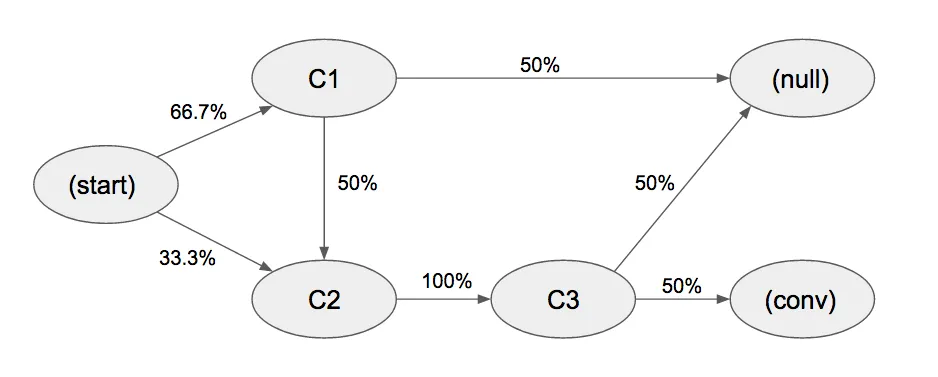

**Pre-procesamiento de los datos**

In [8]:
import numpy as np
import pandas as pd


In [5]:
url = 'https://raw.githubusercontent.com/jakebenn/multi-touch-attribution-markov-chains/master/simple_conversion_data.csv'
df = pd.read_csv(url, header=None)

In [6]:
df.insert(0, 'Start', 'Start')

In [7]:
df

,Start,0,1,2,3
0,Start,C1,C2,C3,Conversion
1,Start,C1,NaN,NaN,NaN
2,Start,C2,C3,NaN,NaN


In [9]:
transitions = list()
for n in range(0, len(df.columns)-1):
    df_transition = pd.DataFrame({
        't': df.iloc[:,n], 
        't_plus_1': df.iloc[:,n+1]
    })
    transitions.append(df_transition)
df_transitions = pd.concat(transitions)

In [10]:
df_transitions.dropna(subset=['t'], inplace=True)

In [11]:
df_transitions.fillna('Exit', inplace=True)

In [12]:
df_transitions

,t,t_plus_1
0,Start,C1
1,Start,C1
2,Start,C2
0,C1,C2
1,C1,Exit
2,C2,C3
0,C2,C3
2,C3,Exit
0,C3,Conversion


In [13]:
df_initial_state_counts = df_transitions.groupby(by=['t'], as_index=False).count()
df_initial_state_counts.rename(columns={'t_plus_1':'count_of_t'}, inplace=True)

In [14]:
df_initial_state_counts

,t,count_of_t
0,C1,2
1,C2,2
2,C3,2
3,Start,3


**Cálculo de las probabilidades de transición**

In [15]:
df_transitions = pd.merge(df_transitions, df_initial_state_counts, on='t', how='inner')

In [16]:
df_transitions

,t,t_plus_1,count_of_t
0,Start,C1,3
1,Start,C1,3
2,Start,C2,3
3,C1,C2,2
4,C1,Exit,2
5,C2,C3,2
6,C2,C3,2
7,C3,Exit,2
8,C3,Conversion,2


In [17]:
df_transitions['probability'] = 1/df_transitions['count_of_t']

In [18]:
df_transitions

,t,t_plus_1,count_of_t,probability
0,Start,C1,3,0.333333
1,Start,C1,3,0.333333
2,Start,C2,3,0.333333
3,C1,C2,2,0.500000
4,C1,Exit,2,0.500000
5,C2,C3,2,0.500000
6,C2,C3,2,0.500000
7,C3,Exit,2,0.500000
8,C3,Conversion,2,0.500000


In [19]:
df_transition_prob = df_transitions.groupby(by=['t', 't_plus_1'], as_index=False).sum()
df_transition_prob.drop(['count_of_t'], axis=1, inplace=True)

In [20]:
df_transition_prob

,t,t_plus_1,probability
0,C1,C2,0.500000
1,C1,Exit,0.500000
2,C2,C3,1.000000
3,C3,Conversion,0.500000
4,C3,Exit,0.500000
5,Start,C1,0.666667
6,Start,C2,0.333333


**Calculo de las probabilidades de conversion**

In [21]:
def print_node(node, debug=False):
 
    if not debug:
        return
    
    if node['t_plus_1'] in ['Exit', 'Conversion']:
        node_type = 'Leaf'
    else:
        node_type = 'Parent'
    
    print('%s > %s' % (node['t'], node['t_plus_1']))
    print('Type: %s' % node_type)
    print('Prob: %0.2f' % node['probability'])
    print('----------------------------')

In [30]:
calculated_node_probabilities = dict()

def calc_conversion_probability(starting_state, df_transitions, cum_probability, calculated_nodes, debug=True):
   
        
    
    df_nodes = df_transitions[df_transitions['t'] == starting_state]

    
 
    
    node_conversion_probability = 0
    
    child_node_proabilities = []
    
    for index, row in df_nodes.iterrows():
        
       
        if row['t_plus_1'] == 'Exit':
            print_node(row, debug)
            child_node_proabilities.append(0)
        
        elif row['t_plus_1'] == 'Conversion':
            print_node(row, debug)
            child_node_proabilities.append(row['probability'])
        
      
        else:
            
       
            if row['t_plus_1'] in calculated_nodes:
                if debug:
                    print('Cache Hit for %s! Cum probability from child: %0.2f' % (row['t_plus_1'], calculated_nodes[row['t_plus_1']]))
                child_probability = calculated_nodes[row['t_plus_1']]
            
     
            else:
             
                child_probability = calc_conversion_probability(row['t_plus_1'], 
                                                                df_transitions, 
                                                                cum_probability + row['probability'],
                                                                calculated_nodes, 
                                                                debug)
                node_conversion_prob = child_probability * row['probability']
                
            print_node(row, debug)
            child_node_proabilities.append(node_conversion_prob)
                    
            if debug:
                print('%s > %s' % (row['t'], row['t_plus_1']))
                print('Cum Prob from Child : %0.2f' % child_probability)
                print('Prob to Child Node  : %0.2f' % row['probability'])
                print('Node Conv Proability: %0.2f' % node_conversion_prob)
                print('----------------------------')
    
    total_node_probability = sum(child_node_proabilities)
    if debug:
        print('Node Conversion Probability for %s: %0.2f' % (starting_state, total_node_probability))
        print('----------------------------')
    
   
    calculated_node_probabilities[starting_state] = total_node_probability
        
    return total_node_probability
        

In [31]:
starting_node = 'Start'
print('====== START DEBUG PRINT ======')
total_probability = calc_conversion_probability(starting_node, df_transition_prob, 0, calculated_node_probabilities)
print('====== END DEBUG PRINT ======')
print(' ')
print('Total Conversion Probability from %s: %0.2f' % (starting_node, total_probability))

====== START DEBUG PRINT ======
C3 > Conversion
Type: Leaf
Prob: 0.50
----------------------------
C3 > Exit
Type: Leaf
Prob: 0.50
----------------------------
Node Conversion Probability for C3: 0.50
----------------------------
C2 > C3
Type: Parent
Prob: 1.00
----------------------------
C2 > C3
Cum Prob from Child : 0.50
Prob to Child Node  : 1.00
Node Conv Proability: 0.50
----------------------------
Node Conversion Probability for C2: 0.50
----------------------------
C1 > C2
Type: Parent
Prob: 0.50
----------------------------
C1 > C2
Cum Prob from Child : 0.50
Prob to Child Node  : 0.50
Node Conv Proability: 0.25
----------------------------
C1 > Exit
Type: Leaf
Prob: 0.50
----------------------------
Node Conversion Probability for C1: 0.25
----------------------------
Start > C1
Type: Parent
Prob: 0.67
----------------------------
Start > C1
Cum Prob from Child : 0.25
Prob to Child Node  : 0.67
Node Conv Proability: 0.17
----------------------------
Cache Hit for C2! Cum prob

**Calculando el Removal Effect**

In [32]:
df_transition_prob

,t,t_plus_1,probability
0,C1,C2,0.500000
1,C1,Exit,0.500000
2,C2,C3,1.000000
3,C3,Conversion,0.500000
4,C3,Exit,0.500000
5,Start,C1,0.666667
6,Start,C2,0.333333


In [33]:
unique_channels = df_transition_prob[df_transition_prob['t'] != 'Start']['t'].unique()

In [35]:
pd.options.mode.chained_assignment = None  # I know, this makes me a very bad person.
removal_effects = dict()

for channel in unique_channels:
    

    df_reduced_graph = df_transition_prob[df_transition_prob['t'] != channel]
    df_reduced_graph.loc[df_reduced_graph['t_plus_1']==channel, 't_plus_1'] = 'Exit'
    
   
    calculated_node_probabilities = dict()
    new_total_probability = calc_conversion_probability('Start', 
                                                        df_reduced_graph, 
                                                        0, 
                                                        calculated_node_probabilities, 
                                                        debug=False)
    

    removal_effect = (total_probability - new_total_probability)/total_probability
    removal_effects[channel] = removal_effect

In [36]:
print('Removal effect by channel:')
for key, value in removal_effects.items(): 
    print('%s: %0.2f' % (key, value))

Removal effect by channel:
C1: 0.50
C2: 1.00
C3: 1.00
